## Prediction Model with Prophet

In [1]:
# import common 
import sys
sys.path.append('../common/')
from functions import get_view_counts

# import libraries
import pandas as pd
import numpy as np

from pymongo import MongoClient
from fbprophet import Prophet
from matplotlib import pyplot as plt
from matplotlib import dates as mdates

### Make a dataframe from mongodb

**Collections**
* video_detail : contains title, url, published date, video_id of video
* view_count : contains # of views, comments, likes

In [2]:
# connect mongodb through ssh tunnel
connection = MongoClient(port=47017)
db = connection['youtube_scrap']

### Load video detail to dataframe

In [3]:
# load from mongodb
video_coll = db['video_detail']
video_cur = video_coll.find({})
videos = [video for video in video_cur]

In [4]:
# select a video
video = videos[9]

In [5]:
# get view_counts for selected video
df = get_view_counts(db, video['video_id'])
df.head()

,_id,comment_count,like_count,timestamp,title,video_id,view_count
0,5d13b7a19ec6103a9817d75e,4495,183308,2019-06-26 18:21:16.925,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5505871
1,5d13c37b9ec6103a9817d89b,4497,183393,2019-06-26 19:11:51.844,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5509723
2,5d13c4779ec6103a9817d8af,4497,183397,2019-06-26 19:16:03.135,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5510424
3,5d13cdb89ec6103a9817d993,4498,183476,2019-06-26 19:55:32.016,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5514608
4,5d13d3ad9ec6103a9817da31,4501,183530,2019-06-26 20:20:57.911,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5517267


### Make a prediction with Prophet

In [6]:
# initialize Prophet model
m = Prophet()

In [7]:
# prepare dataframe for Prophet
est_df = df[['timestamp', 'view_count']]
est_df.columns = ['ds', 'y']
est_df.head()

,ds,y
0,2019-06-26 18:21:16.925,5505871
1,2019-06-26 19:11:51.844,5509723
2,2019-06-26 19:16:03.135,5510424
3,2019-06-26 19:55:32.016,5514608
4,2019-06-26 20:20:57.911,5517267


In [8]:
# fit to model
m.fit(est_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/Users/teo/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [9]:
# make dataframe for estimatin after 3 days 
future = m.make_future_dataframe(periods=3)
future.tail()

,ds
555,2019-07-10 16:29:28.679
556,2019-07-10 17:14:46.751
557,2019-07-11 17:14:46.751
558,2019-07-12 17:14:46.751
559,2019-07-13 17:14:46.751


In [10]:
# perform predict 
forecast = m.predict(future)

In [11]:
# extracting some data
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
555,2019-07-10 16:29:28.679,6.444536e+06,6.443503e+06,6.445496e+06
556,2019-07-10 17:14:46.751,6.445914e+06,6.444935e+06,6.446906e+06
557,2019-07-11 17:14:46.751,6.488143e+06,6.472194e+06,6.500851e+06
558,2019-07-12 17:14:46.751,6.530372e+06,6.485314e+06,6.571291e+06
559,2019-07-13 17:14:46.751,6.572600e+06,6.488434e+06,6.645366e+06


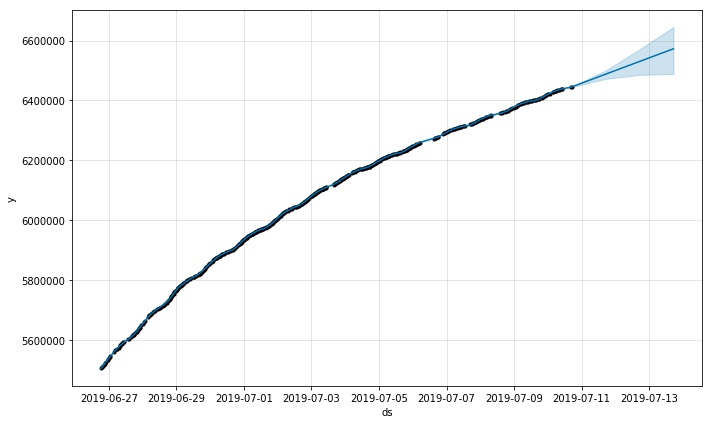

In [12]:
# Draw a chart with forecast (prophet function)
fig1 = m.plot(forecast)

### What's in the forecast

In [13]:
# extract last 3 rows in forecast 
# (but one more row is needed for chart)
df = forecast.tail(4)
df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
556,2019-07-10 17:14:46.751,6.449701e+06,6.444935e+06,6.446906e+06,6.449701e+06,6.449701e+06,-3786.610878,-3786.610878,-3786.610878,-3786.610878,-3786.610878,-3786.610878,0.0,0.0,0.0,6.445914e+06
557,2019-07-11 17:14:46.751,6.491930e+06,6.472194e+06,6.500851e+06,6.475752e+06,6.504500e+06,-3786.610878,-3786.610878,-3786.610878,-3786.610878,-3786.610878,-3786.610878,0.0,0.0,0.0,6.488143e+06
558,2019-07-12 17:14:46.751,6.534158e+06,6.485314e+06,6.571291e+06,6.488928e+06,6.574500e+06,-3786.610878,-3786.610878,-3786.610878,-3786.610878,-3786.610878,-3786.610878,0.0,0.0,0.0,6.530372e+06
559,2019-07-13 17:14:46.751,6.576387e+06,6.488434e+06,6.645366e+06,6.491959e+06,6.649369e+06,-3786.610878,-3786.610878,-3786.610878,-3786.610878,-3786.610878,-3786.610878,0.0,0.0,0.0,6.572600e+06


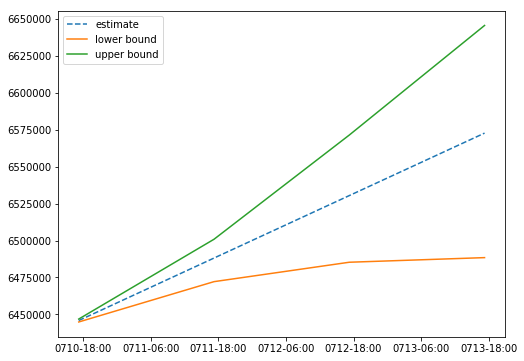

In [14]:
# Draw chart with 3 values in forecast
# yhat, yhat_upper, yhat_lower
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df['ds'], df['yhat'], '--', label='estimate')
ax.plot(df['ds'], df['yhat_lower'], '-', label='lower bound')
ax.plot(df['ds'], df['yhat_upper'], '-', label='upper bound')

hours = mdates.HourLocator(interval = 12)
h_fmt = mdates.DateFormatter('%m%d-%H:%M')

ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
plt.legend()
plt.show()

### Chart for past + forecast

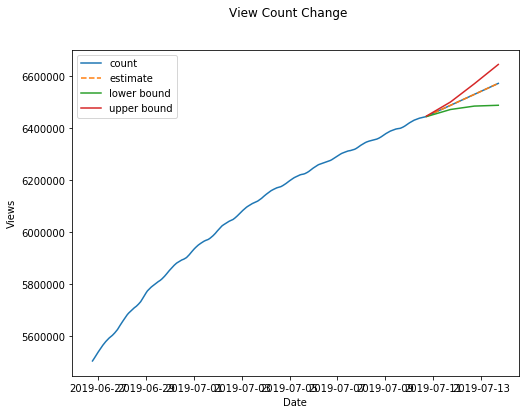

In [15]:
# Draw chart with 3 values in forecast
# yhat, yhat_upper, yhat_lower
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(forecast['ds'], forecast['yhat'], '-', label='count')
ax.plot(df['ds'], df['yhat'], '--', label='estimate')
ax.plot(df['ds'], df['yhat_lower'], '-', label='lower bound')
ax.plot(df['ds'], df['yhat_upper'], '-', label='upper bound')

fig.suptitle('View Count Change')
ax.set_xlabel('Date')
ax.set_ylabel('Views')
plt.legend()
plt.show()

#### Make a draw_combine_chart

In [16]:
# def draw_combine_chart(data,
#                        forecast_period=3,
#                        fields=['view_count'], 
#                        title='Count by Time', 
#                        figsize=(12, 6)):
#     """Draw a chart with data(timestamp, counts)"""
#     fig, ax = plt.subplots(figsize=figsize)
#     fig.suptitle(title)

#     divider = 1
#     div_label = ''

#     for field in fields:
#         divider = 1_000 if data[field].max() > 90_000 else divider
#         div_label = ' (K)' if divider == 1_000 else div_label

#         divider = 1_000_000 if data[field].max() > 90_000_000 else divider
#         div_label = ' (M)' if divider == 1_000_000 else div_label

#         ax.plot(data['timestamp'], 
#                 data[field] / divider, 
#                 '-',
#                 label=field)

#     hours = mdates.HourLocator(interval = 4)
#     h_fmt = mdates.DateFormatter('%m%d-%H:%M')

#     ax.xaxis.set_major_locator(hours)
#     ax.xaxis.set_major_formatter(h_fmt)

#     ax.set_xlabel('Time')
#     ax.set_ylabel('Count' + div_label)
#     fig.autofmt_xdate()
#     plt.legend()
#     plt.show()

In [26]:
forecast['yhat'].tail(1).values[0]

6572600.267115509

### Accuracy of estimation

In [17]:
pass